# Quick Dash score
to assess whethere movement quality is related to patient reported functioning. 
We expect that movement quality post-operatively is related to patient reported disability and pain scores. 
And that there are differences in movement quality between the people with a DASH < 15 and those above 15. The threshold of 15 is chosen because this indicates whether someome is 'disabled' or not

1) Only retain t1 (1 months post-op data) 
and remove participants with to many NaN

2) Calculate the total DASH score

Berekening Quick DASH beperkingen en symptomen score:  
{(Som van de antwoorden op N items / N ) – 1} x 25 
N = aantal ingevulde antwoorden  
Let op: de Quick DASH score mag niet berekend worden als meer dan 1 vraag niet beantwoord is.


3) Split group on disabled group and non-disabled

4) Correlate the Quick Dash scores with movement quality. i.e. do people with a higher score perform better?


In [87]:
import numpy as np
import pandas as pd
import ptitprince as pt
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

#### Input data sets
1) Dash scores

In [76]:
raw = pd.read_csv("C:\\Users\\u0117545\\KU Leuven\\An De Groef - DATA\\XsensTest\\QuickDASH\\UPLIFTBC-QuickDASH_DATA_2022-10-31_1406 (1).csv",
                   sep=';')

In [77]:
# only retain T1 of the dash scores 
idx = raw['redcap_event_name'].str.contains('t1')
mask = np.where(idx)[0]
raw = raw.iloc[mask]
raw.head()

,record_id,redcap_event_name,quickdash_1,quickdash_2,quickdash_3,quickdash_4,quickdash_5,quickdash_6,quickdash_7,quickdash_8,quickdash_9,quickdash_10,quickdash_11
1,BC_001,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,BC_002,t1_1_month_postsur_arm_1,2.0,3.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,1.0
6,BC_003,t1_1_month_postsur_arm_1,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0
9,BC_005,t1_1_month_postsur_arm_1,3.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0
11,BC_006,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [78]:
# remove participants with more than 2 NaNs
# Remove rows with missing values
print("Before removing rows with missing data: {} rows".format(len(raw)))
df_dash = raw.dropna(thresh=raw.shape[1]-1, axis=0)
print("After removing rows with missing data: {} rows".format(len(df_dash)))

Before removing rows with missing data: 21 rows
After removing rows with missing data: 15 rows


2) Movement quality parameters

In [79]:
df_qual = pd.read_excel('C:/Users/u0117545/Documents/GitHub/ULIFT_BC/Output/MoveQual_aff.xlsx', sheet_name = 'T1')
df_qual.head()

,ppID,trial,time,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,...,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,sparc_x,sparc_y,sparc_z,sparc_res,LDLJ_A
0,BC_001,F_R_001,T1,7.701734,8.671551,1.385935,6.587047,0.188650,0.639654,0.117585,...,0.951799,1.301812,0.509471,0.336057,0.792152,-4.924341,-3.823578,-5.195009,-2.826718,-8.804562
1,BC_002,F_L_001,T1,4.819965,2.955782,4.651802,3.021216,0.902024,1.048165,0.832677,...,2.338018,3.361040,0.529273,0.415402,0.739805,-3.635514,-2.818207,-3.670352,-2.103190,-7.668037
2,BC_003,F_R_001,T1,2.935410,1.640538,3.245344,4.049951,0.549589,1.416456,0.435703,...,4.132086,6.322299,0.435838,0.582890,0.685773,-2.999487,-2.863180,-3.500903,-1.937020,-7.086592
3,BC_005,F_R_001,T1,3.296498,2.138640,2.523334,2.579761,1.070558,1.219464,0.610133,...,2.782943,3.787381,0.516137,0.354723,0.779599,-4.989269,-2.960899,-3.663430,-2.240403,-7.479738
4,BC_006,F_R_001,T1,2.100760,1.943798,2.159363,5.518124,0.369269,0.757041,0.292400,...,2.455728,3.444624,0.563278,0.304754,0.768013,-8.440110,-2.915060,-3.413227,-2.345322,-8.140653


#### Calculate total dash scores

In [80]:
som = df_dash.iloc[:,2:].sum(axis='columns')
col_n_counts = np.sum(df_dash.applymap(lambda x: 0 if pd.isnull(x) else 1), axis=1)-2
complete = col_n_counts.apply(lambda x:  x >= 10 )

total_score = ((som/col_n_counts)-1) * 25

print('Average score over all participants and timepoints = {}'.format(np.mean(total_score)))
print('Maximum and minumum scores are {} & {} respectively'.format(total_score.max(), total_score.min()))



Average score over all participants and timepoints = 26.363636363636363
Maximum and minumum scores are 70.45454545454545 & 0.0 respectively


In [81]:
#set-up dataframe for total dash scores. 
d = {'ppID': df_dash['record_id'],
    'total_score': total_score}
df_totaldash = pd.DataFrame(data=d)

In [82]:
# merge the dataframes on ppID remove time and trial (since it is all 1 months post op)
# use df for all furhter analysis
df = df_totaldash.merge(df_qual)
df = df.drop(labels=['trial', 'time'], axis = 1)
df.head()

,ppID,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,...,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,sparc_x,sparc_y,sparc_z,sparc_res,LDLJ_A
0,BC_001,0.000000,7.701734,8.671551,1.385935,6.587047,0.188650,0.639654,0.117585,0.201132,...,0.951799,1.301812,0.509471,0.336057,0.792152,-4.924341,-3.823578,-5.195009,-2.826718,-8.804562
1,BC_002,20.454545,4.819965,2.955782,4.651802,3.021216,0.902024,1.048165,0.832677,0.973957,...,2.338018,3.361040,0.529273,0.415402,0.739805,-3.635514,-2.818207,-3.670352,-2.103190,-7.668037
2,BC_003,15.909091,2.935410,1.640538,3.245344,4.049951,0.549589,1.416456,0.435703,0.520216,...,4.132086,6.322299,0.435838,0.582890,0.685773,-2.999487,-2.863180,-3.500903,-1.937020,-7.086592
3,BC_005,29.545455,3.296498,2.138640,2.523334,2.579761,1.070558,1.219464,0.610133,0.914877,...,2.782943,3.787381,0.516137,0.354723,0.779599,-4.989269,-2.960899,-3.663430,-2.240403,-7.479738
4,BC_006,0.000000,2.100760,1.943798,2.159363,5.518124,0.369269,0.757041,0.292400,0.383689,...,2.455728,3.444624,0.563278,0.304754,0.768013,-8.440110,-2.915060,-3.413227,-2.345322,-8.140653


#### 3) Split group on disabled group and non-disabled

In [83]:
# find the people with a dash score higher than 15
idx = df['total_score'] >= 15
mask = np.where(idx)[0]
pain = df.iloc[mask]
pain['group'] = 'pain'

# find the people with a dash score lower than 15
idx = df['total_score'] < 15
mask = np.where(idx)[0]
no_pain = df.iloc[mask]
no_pain['group'] = 'no_pain'

print('number of people with perceived disablity: {}'.format(len(pain)))
print('number of people with no perceived disablity: {}'.format(len(no_pain)))

number of people with perceived disablity: 9
number of people with no perceived disablity: 6


C:\Users\u0117545\AppData\Local\Temp/ipykernel_13068/3430380958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pain['group'] = 'pain'
C:\Users\u0117545\AppData\Local\Temp/ipykernel_13068/3430380958.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_pain['group'] = 'no_pain'


In [85]:
df2 = pd.concat([pain, no_pain], axis=0, ignore_index=True)
df2

,ppID,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,...,rms_res,rmsr_x,rmsr_y,rmsr_z,sparc_x,sparc_y,sparc_z,sparc_res,LDLJ_A,group
0,BC_002,20.454545,4.819965,2.955782,4.651802,3.021216,0.902024,1.048165,0.832677,0.973957,...,3.361040,0.529273,0.415402,0.739805,-3.635514,-2.818207,-3.670352,-2.103190,-7.668037,pain
1,BC_003,15.909091,2.935410,1.640538,3.245344,4.049951,0.549589,1.416456,0.435703,0.520216,...,6.322299,0.435838,0.582890,0.685773,-2.999487,-2.863180,-3.500903,-1.937020,-7.086592,pain
2,BC_005,29.545455,3.296498,2.138640,2.523334,2.579761,1.070558,1.219464,0.610133,0.914877,...,3.787381,0.516137,0.354723,0.779599,-4.989269,-2.960899,-3.663430,-2.240403,-7.479738,pain
3,BC_007,52.272727,3.753946,1.833849,4.072082,3.349736,0.757781,0.958627,0.677292,0.954410,...,4.096456,0.560511,0.379621,0.736013,-6.192428,-2.832467,-3.502628,-2.133120,-6.955509,pain
4,BC_010,65.909091,4.842058,2.307720,2.108348,2.805353,0.888231,0.709530,0.621044,0.863260,...,5.002450,0.430152,0.563123,0.705594,-4.999440,-2.909825,-3.933128,-2.030339,-7.077155,pain
5,BC_014,31.818182,1.688677,1.518837,1.657796,3.913905,0.787001,0.613432,0.389860,0.803082,...,4.164502,0.526215,0.384248,0.758585,-2.756570,-2.999251,-3.423197,-2.099143,-7.125685,pain
6,BC_015,59.090909,3.483982,3.498577,2.644495,0.926591,0.992423,1.140337,0.712091,1.087669,...,5.731385,0.542208,0.360392,0.759032,-6.445304,-2.462617,-2.990519,-2.100652,-6.330608,pain
7,BC_020,70.454545,2.222610,1.496537,1.792251,1.624045,0.639720,0.715992,0.467463,0.786133,...,3.733088,0.498618,0.487473,0.716764,-5.177963,-2.820358,-4.387953,-2.101137,-7.361594,pain
8,BC_021,20.454545,6.371021,0.572642,3.900529,2.230424,0.724186,0.506681,0.434349,0.831449,...,3.798369,0.577759,0.251252,0.776574,-6.942761,-3.149804,-4.275769,-2.384284,-7.485488,pain
9,BC_001,0.000000,7.701734,8.671551,1.385935,6.587047,0.188650,0.639654,0.117585,0.201132,...,1.301812,0.509471,0.336057,0.792152,-4.924341,-3.823578,-5.195009,-2.826718,-8.804562,no_pain


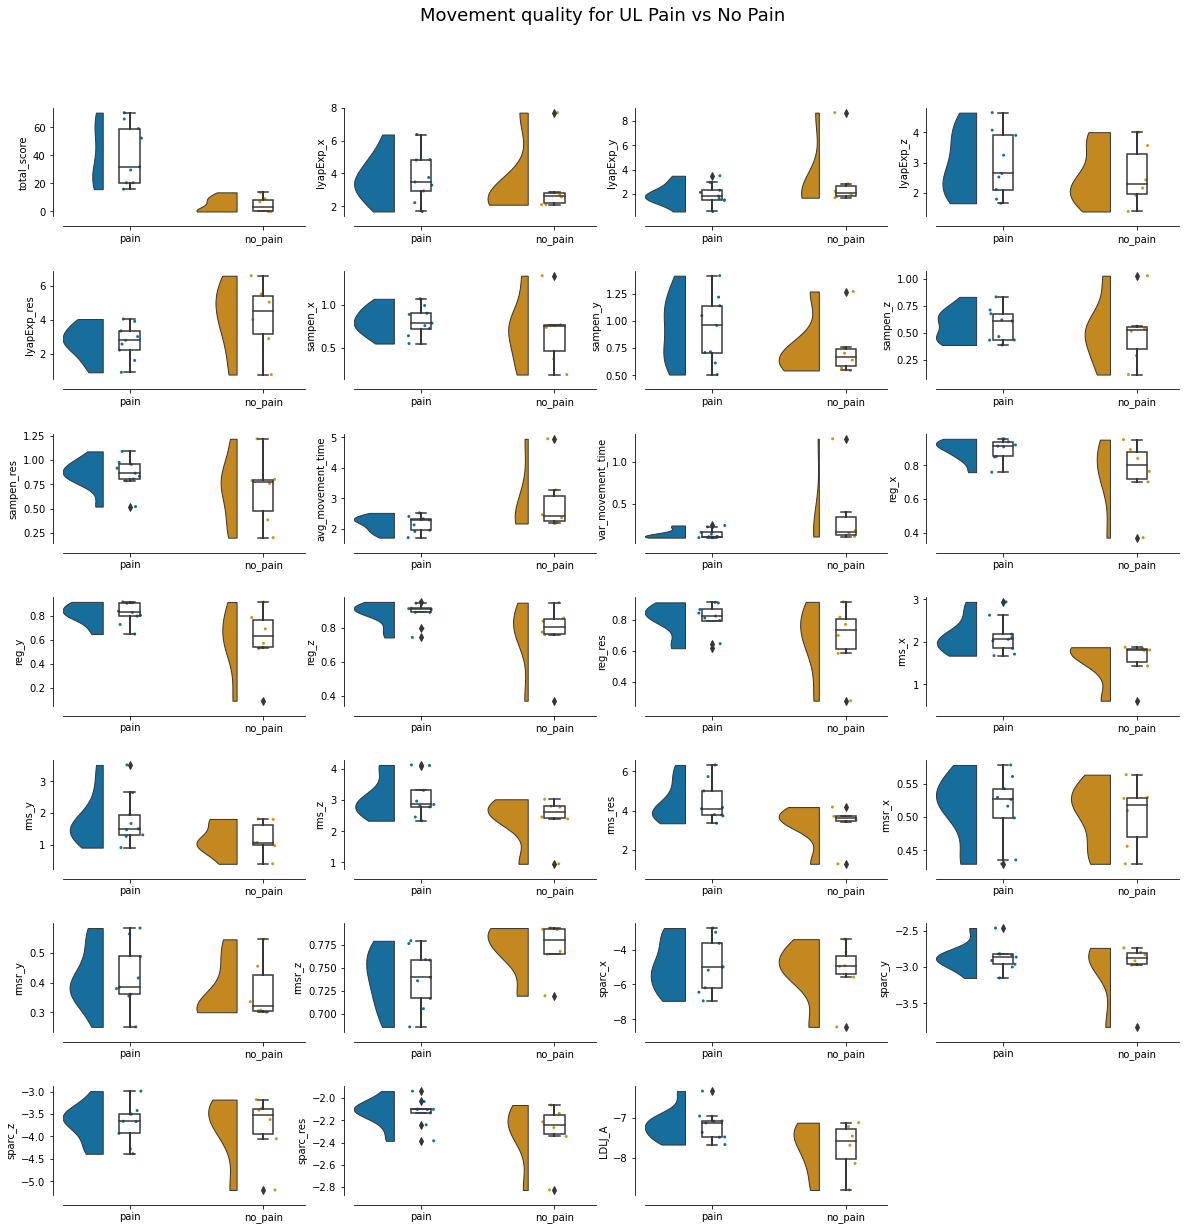

In [89]:
# plot the results
X = df2.drop(['ppID', 'group'], axis = 1)
# find minimium required rows given we want 5 columns
ncols = 4
nrows = len(X.columns) // ncols + (len(X.columns) % ncols > 0)
dx = "group"; ort = "v"; pal = 'colorblind'; sigma = .6; viol = .6; mv = .0

f = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Movement quality for UL DASH >= 15 vs DASH < 15", fontsize=18, y=0.95)

f.tight_layout();
offset = 0.1;

for n, columns in enumerate(X.columns):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)
    
    # filter df and plot ticker on the new subplot axis
    #df[df["ticker"] == ticker].plot(ax=ax)
     
    pt.RainCloud(x = dx, y = columns, data = df2, ax = ax,
                palette = pal, bw = sigma, width_viol = viol,
                orient = ort, move = mv)
    sns.despine(offset=10)
    ax.set_xlabel('')

In [93]:
for var in df2.columns:
    print('Analyzing {}'.format(var))
    if var == 'ppID' or var == 'group':
        print(80 * '_' + '\n')
    else:
        t_statistic, pvalue = stats.mannwhitneyu(pain[var], no_pain[var])
        print(t_statistic, round(pvalue, ndigits=4))
        
        print(80* "_" + "\n" )
        

Analyzing ppID
________________________________________________________________________________

Analyzing total_score
54.0 0.0017
________________________________________________________________________________

Analyzing lyapExp_x
37.0 0.2721
________________________________________________________________________________

Analyzing lyapExp_y
19.0 0.3884
________________________________________________________________________________

Analyzing lyapExp_z
33.0 0.5287
________________________________________________________________________________

Analyzing lyapExp_res
14.0 0.1447
________________________________________________________________________________

Analyzing sampen_x
34.0 0.4559
________________________________________________________________________________

Analyzing sampen_y
36.0 0.3277
________________________________________________________________________________

Analyzing sampen_z
33.0 0.5287
________________________________________________________________________